<a href="https://colab.research.google.com/github/lm-foletto/precision-agriculture/blob/main/ML_AG_ES_Intro2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso de Uso: Creando indices espectrales con imagenes de Drones usando Python


En este ejemplo usaremos polígonos para extraer valores de índices espectrales y el CHM:

Link: https://drive.google.com/drive/folders/1VGXbQX8qCFWy_QgilE0Uyn2Taau4Zo5d?usp=sharing

In [ ]:
!pip install rasterio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import json
import cv2

Configuremos las rutas de los archivos:

In [ ]:
img_path = '/content/drive/MyDrive/Datasets_AG/Orto_DEM_UVA/Ortho-DrnMppr.tif'
chm_path = ("/content/drive/MyDrive/Datasets_AG/Orto_DEM_UVA/CHM.tif")
aoi_path = '/content/drive/MyDrive/Datasets_AG/Orto_DEM_UVA/Analisys/AOI_UVA.shp'
lotes_path = '/content/drive/MyDrive/Datasets_AG/Orto_DEM_UVA/Analisys/Lotes.shp'
linhas_path = '/content/drive/MyDrive/Datasets_AG/Orto_DEM_UVA/Analisys/Linhas.shp'

Abramos el archivo de polígono y luego generemos una composición RGB:

In [ ]:
aoi = gpd.read_file(aoi_path)
lotes = gpd.read_file(lotes_path)

In [ ]:
with rasterio.open(img_path) as src:
  R = src.read(3)
  G = src.read(2)
  B = src.read(1)

In [ ]:
R = R / (2**16)
G = G / (2**16)
B = B / (2**16)

In [ ]:
rgb = np.dstack((R,G,B))

In [ ]:
rgb.max()

0.8567352294921875

In [ ]:
rgb.shape

(7542, 9418, 3)

Presentemos la imagen con los polígonos:

In [ ]:
bounds  = src.bounds
Xmin = bounds[0]
Ymin = bounds[1]
Xmax = bounds[2]
Ymax = bounds[3]
extends = (Xmin, Xmax, Ymin, Ymax)

<Axes: >

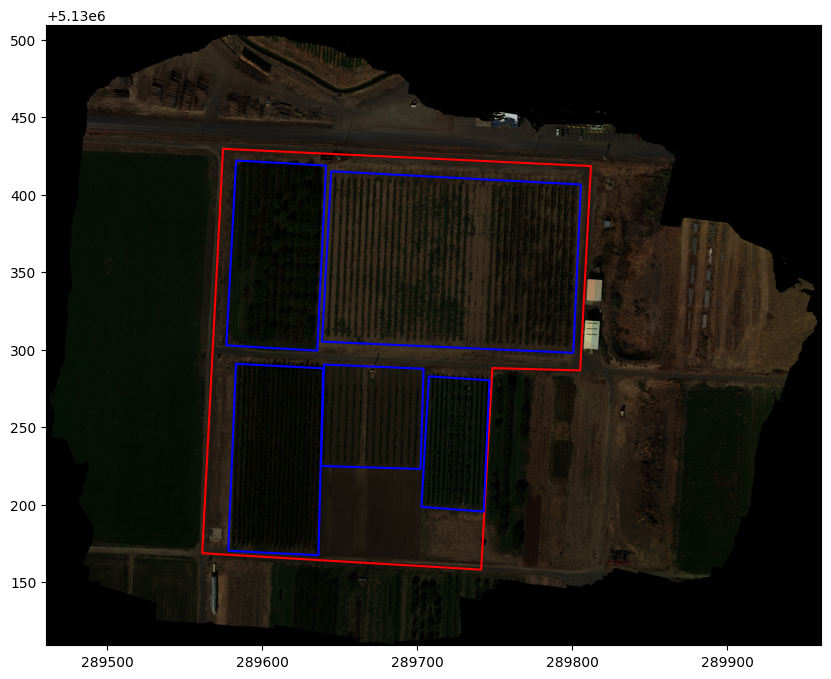

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb * 1.4, extent=extends)
aoi.boundary.plot(ax=ax, edgecolor='red')
lotes.boundary.plot(ax=ax, edgecolor='blue')

Usemos el polígono del área de interés para recortar primero el CHM:

In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

def clip_image(path_to_clip,gdf_AOI,path_to_save):
  coords = getFeatures(gdf_AOI)
  with rasterio.open(path_to_clip) as src:
    out_img, out_transform = mask(dataset=src, shapes=coords, crop=True)
    out_meta = src.meta.copy()
  out_meta.update({"driver": "GTiff",
                    "height": out_img.shape[1],
                    "width": out_img.shape[2],
                    "compress":'lzw',
                    "transform": out_transform})
  with rasterio.open(path_to_save, "w", **out_meta) as dest:
      dest.write(out_img)

In [ ]:
def reasmpled_img(path_img,path_save,height,width):
  with rasterio.open(path_img) as dataset:
      data = dataset.read(
          out_shape=(
              dataset.count,
              int(height),
              int(width)
          ),
          resampling=Resampling.bilinear
      )
      transform = dataset.transform * dataset.transform.scale(
          (dataset.width / data.shape[-1]),
          (dataset.height / data.shape[-2])
      )
      profile = dataset.profile
  profile.update(transform=transform, driver='GTiff', height=data.shape[-2], width=data.shape[-1], crs=dataset.crs, compress='lzw')
  with rasterio.open(os.path.join(path_save),'w', **profile) as dst:
    dst.write(data)

In [ ]:
path_repj = '/content/CLIP'
if not os.path.isdir(path_repj):
  os.mkdir(path_repj)

chm_path_clip = '/content/CLIP/CHM_clip.tif'
img_path_clip = '/content/CLIP/RGB_clip.tif'

gdf_AOI = gpd.read_file(aoi_path)


clip_image(chm_path,gdf_AOI,chm_path_clip)
clip_image(img_path,gdf_AOI,img_path_clip)

In [ ]:
src_img = rasterio.open(img_path_clip)

In [ ]:
height = src_img.height
width = src_img.width

In [ ]:
reasmpled_img(chm_path_clip,'/content/CLIP/CHM_resampled.tif',height,width)

Ahora creemos algunos índices espectrales y córtelos con el área de interés:

In [ ]:
src_chm = rasterio.open('/content/CLIP/CHM_resampled.tif')
chm = src_chm.read()

In [ ]:
chm.shape

(1, 5114, 4725)

In [ ]:
img = src_img.read()

In [ ]:
img.shape

(7, 5114, 4725)

In [ ]:
R = img[2] / (2**16)
G = img[1] / (2**16)
B = img[0] / (2**16)
RE = img[4] / (2**16)
N = img[3] / (2**16)
T = (img[5]/100)-273.15

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
ndvi = (N.astype(float) - R.astype(float)) / (N + R)

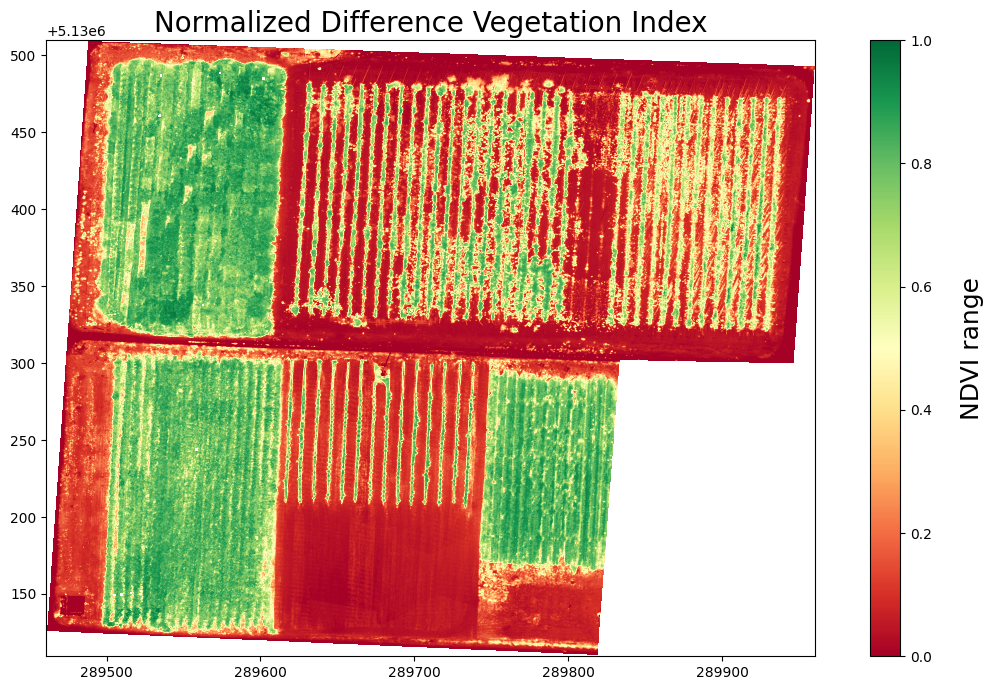

In [ ]:
plt.figure(figsize=[14,8])
plt.imshow(ndvi, extent=extends, cmap='RdYlGn', vmin=0, vmax=1)
plt.title('Normalized Difference Vegetation Index',fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('NDVI range',rotation=90,labelpad=20,fontsize = 18)

In [ ]:
out_target = src_img.meta.copy()

In [ ]:
out_target.update({"driver": "GTiff",
                               "dtype":rasterio.float32,
                               "compress":'lzw',
                               "count":1})
path_exp_target = '/content/NDVI.tif'
with rasterio.open(path_exp_target, 'w', **out_target) as msk:
    msk.write(ndvi, indexes=1)

In [ ]:
ndre = (N.astype(float) - RE.astype(float)) / (N + RE)

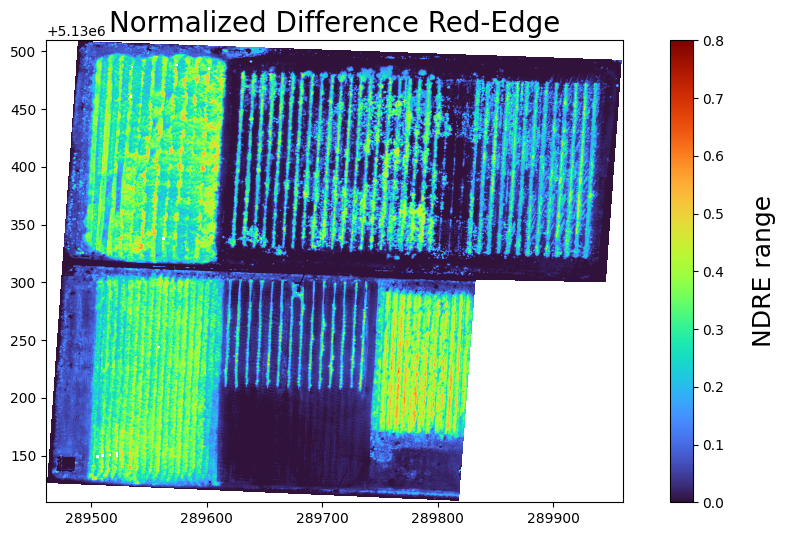

In [ ]:
plt.figure(figsize=[12,6])
plt.imshow(ndre, extent=extends, cmap='turbo', vmin=0, vmax=0.8)
plt.title('Normalized Difference Red-Edge',fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('NDRE range',rotation=90,labelpad=20,fontsize = 18)

In [ ]:
out_target = src_img.meta.copy()

In [ ]:
out_target.update({"driver": "GTiff",
                               "dtype":rasterio.float32,
                               "compress":'lzw',
                               "count":1})
path_exp_target = '/content/NDRE.tif'
with rasterio.open(path_exp_target, 'w', **out_target) as msk:
    msk.write(ndre, indexes=1)

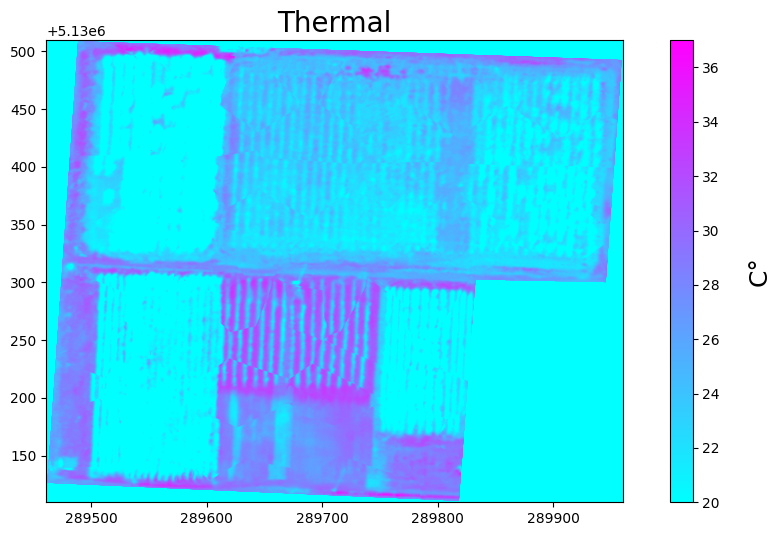

In [ ]:
plt.figure(figsize=[12,6])
plt.imshow(T, extent=extends, cmap='cool', vmin=20, vmax=37)
plt.title('Thermal',fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('C°',rotation=90,labelpad=20,fontsize = 18)

In [ ]:
out_target = src_img.meta.copy()

In [ ]:
out_target.update({"driver": "GTiff",
                               "dtype":rasterio.float32,
                               "compress":'lzw',
                               "count":1})
path_exp_target = '/content/Thermal.tif'
with rasterio.open(path_exp_target, 'w', **out_target) as msk:
    msk.write(T, indexes=1)

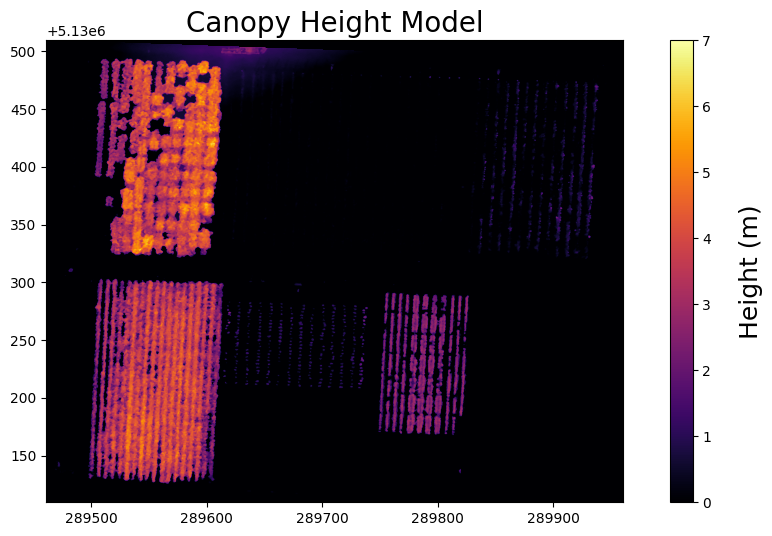

In [ ]:
plt.figure(figsize=[12,6])
plt.imshow(chm[0], extent=extends, cmap='inferno', vmin=0, vmax=7)
plt.title('Canopy Height Model',fontsize = 20)
cbar = plt.colorbar()
cbar.set_label('Height (m)',rotation=90,labelpad=20,fontsize = 18)

Generemos un mapeo del área foliar con NDVI y CHM:

In [ ]:
ndvi.shape

(5114, 4725)

In [ ]:
ret,thresh1 = cv2.threshold(ndvi,0.3,1,cv2.THRESH_BINARY)

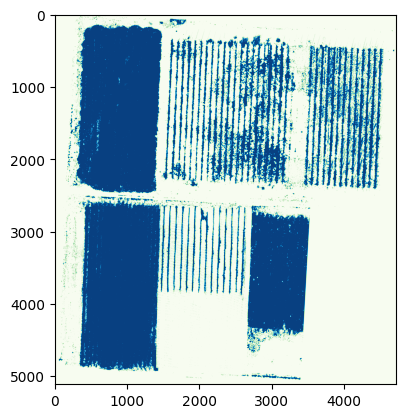

In [ ]:
plt.imshow(thresh1, cmap='GnBu')

In [ ]:
ret,thresh2 = cv2.threshold(chm[0],1,255,cv2.THRESH_BINARY)

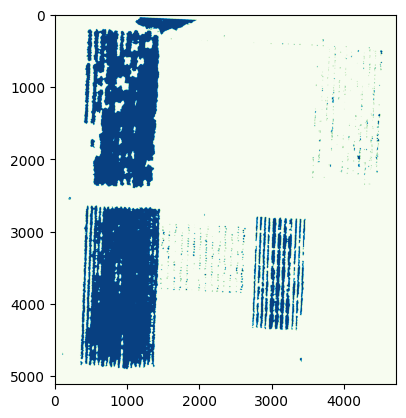

In [ ]:
plt.imshow(thresh2, cmap='GnBu')

In [ ]:
plants_mask =  cv2.bitwise_and(thresh1.astype('uint8'),thresh2.astype('uint8'))

Text(0.5, 1.0, 'Area Foliar')

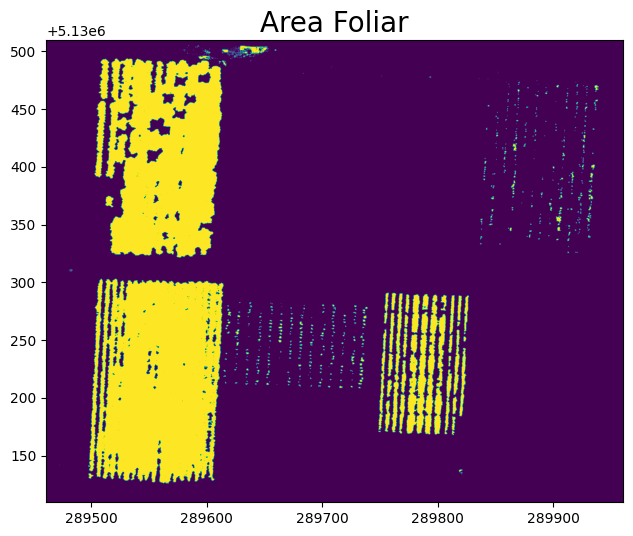

In [ ]:
plt.figure(figsize=[12,6])
plt.imshow(plants_mask, extent=extends)
plt.title('Area Foliar',fontsize = 20)

In [ ]:
out_target = src_img.meta.copy()

In [ ]:
out_target.update({"driver": "GTiff",
                               "dtype":rasterio.float32,
                               "compress":'lzw',
                               "count":1})
path_exp_target = '/content/AF_Mask.tif'
with rasterio.open(path_exp_target, 'w', **out_target) as msk:
    msk.write(plants_mask, indexes=1)

Ahora podemos usar tanto los polígonos como la máscara de área foliar binaria para extraer información, generando un Dataframe:

<Axes: >

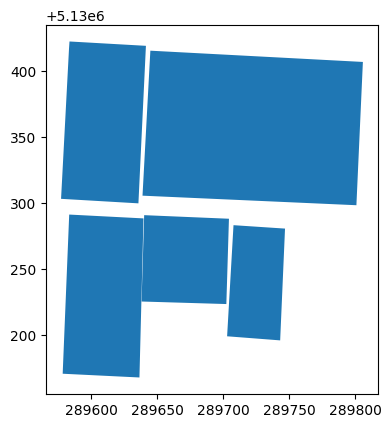

In [ ]:
lotes.plot()

In [ ]:
area_foliar_list = []
percentual_list = []
volume_list = []
alt_list = []
mean_NDVI_SV_list = []
mean_NDVI_V_list = []
mean_NDRE_SV_list = []
mean_NDRE_V_list = []
mean_thermal_list = []
src_msk = rasterio.open('/content/AF_Mask.tif')
src_ndvi = rasterio.open('/content/NDVI.tif')
src_ndre = rasterio.open('/content/NDRE.tif')
src_temp = rasterio.open('/content/Thermal.tif')
src_chm = rasterio.open('/content/CLIP/CHM_resampled.tif')
for feat in json.loads(lotes.to_json())['features']:
  out_msk_img, _ = mask(dataset=src_msk, shapes=[feat['geometry']], crop=True, nodata=-9999)

  valid_values = out_msk_img[out_msk_img != -9999]
  area_foliar = valid_values.sum() * src_msk.res[0] * src_msk.res[1]
  area_foliar_list.append(area_foliar)
  area_total = len(valid_values) * src_msk.res[0] * src_msk.res[1]
  percent = (area_foliar*100) / area_total
  percentual_list.append(percent)

  out_ndvi_img, _ = mask(dataset=src_ndvi, shapes=[feat['geometry']], crop=True, nodata=-9999)
  valid_ndvi_sv = out_ndvi_img[out_ndvi_img != -9999]
  valid_ndvi = out_ndvi_img[out_msk_img == 1]
  mean_NDVI_SV = valid_ndvi_sv.mean()
  mean_NDVI_V = valid_ndvi.mean()
  mean_NDVI_SV_list.append(mean_NDVI_SV)
  mean_NDVI_V_list.append(mean_NDVI_V)


  out_ndre_img, _ = mask(dataset=src_ndre, shapes=[feat['geometry']], crop=True, nodata=-9999)
  valid_ndre_sv = out_ndre_img[out_ndre_img != -9999]
  valid_ndre = out_ndre_img[out_msk_img == 1]
  mean_NDRE_SV = valid_ndre_sv.mean()
  mean_NDRE_V = valid_ndre.mean()
  mean_NDRE_SV_list.append(mean_NDRE_SV)
  mean_NDRE_V_list.append(mean_NDRE_V)


  out_thermal_img, _ = mask(dataset=src_ndre, shapes=[feat['geometry']], crop=True, nodata=-9999)
  valid_thermal = out_thermal_img[out_msk_img == 1]
  mean_thermal = valid_thermal.mean()
  mean_thermal_list.append(mean_thermal)





  out_chm_img, _ = mask(dataset=src_chm, shapes=[feat['geometry']], crop=True, nodata=-9999)

  if out_chm_img.shape[1] > out_msk_img.shape[1]:
      diff = (out_chm_img.shape[1] - out_msk_img.shape[1])
      out_chm_img = out_chm_img[:,diff:,:]

  if out_chm_img.shape[1] < out_msk_img.shape[1]:
      diff = (out_msk_img.shape[1] - out_chm_img.shape[1])
      out_msk_img = out_msk_img[:,diff:,:]


  if out_chm_img.shape[2] > out_msk_img.shape[2]:
      diff = (out_chm_img.shape[2] - out_msk_img.shape[2])
      out_chm_img = out_chm_img[:,:,diff:]

  if out_chm_img.shape[2] < out_msk_img.shape[2]:
      diff = (out_msk_img.shape[2] - out_chm_img.shape[2])
      out_msk_img = out_msk_img[:,:,diff:]



  valid_chm = out_chm_img[out_msk_img == 1]
  volume = valid_chm.sum() * src_chm.res[0] * src_chm.res[1]
  alt_med = valid_chm.mean()
  volume_list.append(volume)
  alt_list.append(alt_med)


In [ ]:
data = np.stack((area_foliar_list,percentual_list,volume_list,alt_list,mean_NDVI_SV_list,mean_NDVI_V_list,mean_NDRE_SV_list,mean_NDRE_V_list,mean_thermal_list)).transpose()

In [ ]:
pd.DataFrame(data=data,columns=['Area Foliar Metro', 'Area Foliar Pct', 'Volume', 'Altura Media', 'NDVI Veg+Solo', 'NDVI Veg','NDRE Veg+Solo', 'NDRE Veg', 'Temperatura Media'])

,Area Foliar Metro,Area Foliar Pct,Volume,Altura Media,NDVI Veg+Solo,NDVI Veg,NDRE Veg+Solo,NDRE Veg,Temperatura Media
0,5742.829472,83.133819,19357.043660,3.368532,NaN,0.780671,NaN,0.319304,0.319304
1,4768.077120,68.389812,16793.940417,3.519953,NaN,0.808526,NaN,0.317600,0.317600
2,120.611085,0.682224,158.653812,1.314592,0.313454,0.610534,0.130696,0.254227,0.254227
3,127.360507,3.046708,165.002557,1.294743,0.243746,0.770871,0.085527,0.298299,0.298299
4,1479.858081,44.097253,3410.521749,2.303182,0.771705,0.794751,0.367830,0.386470,0.386470
